#### CSML1020 Course Project - New Plant Diseases Dectection
#### Authors (Group 3): Paul Doucet, Jerry Khidaroo

#### Initilization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

In [3]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

In [4]:
import tensorflow as tf


In [5]:
# Use this to enable GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [6]:
# # Use this to disable GPU
# tf.config.set_visible_devices([], 'GPU')

In [7]:
from keras.applications.vgg16 import VGG16
import keras
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


#### Model and Benchmarking Function Definitions

In [8]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers

def get_alexnet_model():
    # Initializing the CNN
    classifier = Sequential()

    # Convolution Step 1
    classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

    # Max Pooling Step 1
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    # Convolution Step 2
    classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

    # Max Pooling Step 2
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
    classifier.add(BatchNormalization())

    # Convolution Step 3
    classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    classifier.add(BatchNormalization())

    # Convolution Step 4
    classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    classifier.add(BatchNormalization())

    # Convolution Step 5
    classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

    # Max Pooling Step 3
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    # Flattening Step
    classifier.add(Flatten())

    # Full Connection Step
    classifier.add(Dense(units = 4096, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 4096, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 1000, activation = 'relu'))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 38, activation = 'softmax'))

    classifier.load_weights('best_weights_9.hdf5')

    # we chose to train the top 2 conv blocks, i.e. we will freeze the first 8 layers and unfreeze the rest:
    for i, layer in enumerate(classifier.layers[:20]):
        layer.trainable = False

    # Compiling the Model
    classifier.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
   
    return classifier

In [9]:
def get_model(base_model):
    base_model.trainable=False

    classifier=keras.models.Sequential()
    classifier.add(base_model)
    classifier.add(Flatten())
    
    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [31]:
def get_model_A():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Flatten())
    classifier.add(Dense(38,activation='softmax'))
        
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [32]:
def get_model_B():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Flatten())

    classifier.add(Dense(units = 64, activation = 'relu'))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())

    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [33]:
def get_model_C():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Flatten())

    classifier.add(Dense(units = 64, activation = 'relu'))
    classifier.add(Dropout(0.3))
    classifier.add(BatchNormalization())

    #classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [34]:
def get_model_D():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Dense(units = 64, activation = 'relu'))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Flatten())

    classifier.add(Dense(units = 64, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(BatchNormalization())

    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [14]:
# def get_model_A():
#     classifier = Sequential()
#     classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Flatten())
#     classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(Dense(38,activation='softmax'))
    
#     opt = SGD(lr=0.001, momentum=0.9)
#     classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#     return classifier

In [15]:
# def get_model_B():
#     classifier = Sequential()
#     classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Flatten())
#     classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(Dense(38,activation='softmax'))
    
#     classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return classifier

In [16]:
# def get_model_C():
#     classifier = Sequential()
#     classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Flatten())
#     classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(Dense(38,activation='softmax'))
    
#     classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return classifier

In [17]:
# def get_model_D():
#     classifier = Sequential()
#     classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Dropout(0.2))
#     classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(MaxPooling2D((2, 2)))
#     classifier.add(Flatten())
#     classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#     classifier.add(Dense(38,activation='softmax'))
    
#     classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return classifier

In [18]:
def Save_Benchmark(descr, metric, reset_rb, init_rb):
    global rows_benchmarks
    global df_benchmarks
    if (init_rb):
        rows_benchmarks = []
    else:
        if (reset_rb):
            rows_benchmarks = []

        rows_benchmarks.append([descr, metric])
        df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Pre-Prosessing Steps", "Validation Accuracy"])

In [19]:
def Save_Model_Benchmark(descr, history, reset_rb, init_rb):
    global rows_model_benchmarks
    global df_model_benchmarks
    if (init_rb):
        rows_model_benchmarks = []
    else:
        if (reset_rb):
            rows_model_benchmarks = []

        rows_model_benchmarks.append([descr, history.history['accuracy'][-1], history.history['loss'][-1], history.history['val_accuracy'][-1], 
            history.history['val_loss'][-1],])
        df_model_benchmarks = pd.DataFrame(rows_model_benchmarks, columns=["Classifier", "Accuracy", "Loss", "Validation Accuracy", "Validation Loss"])

In [20]:
def run_model(train_datagen, valid_set, batch_size, epochs):    
    training_set = train_datagen.flow_from_directory(dataDirTrain, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

    train_num = training_set.samples
    valid_num = valid_set.samples

    base_model=VGG16(include_top=False,input_shape=(224,224,3))
    classifier = get_model(base_model)
    
    #fitting images to CNN
    history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size)

    return history

In [51]:
def plot_history(model, history, axs, row):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot   
    axs[row, 0].plot(epochs, acc, color='green', label='Training Accuracy')
    axs[row, 0].plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    axs[row, 0].set_title(model + ' Training and Validation Accuracy')
    axs[row, 0].set_xlabel('Epoch')
    axs[row, 0].set_ylabel('Accuracy')
    axs[row, 0].legend()
    
    #loss plot   
    axs[row, 1].plot(epochs, loss, color='pink', label='Training Loss')
    axs[row, 1].plot(epochs, val_loss, color='red', label='Validation Loss')
    axs[row, 1].set_title(model + ' Training and Validation Loss')
    axs[row, 1].set_xlabel('Epoch')
    axs[row, 1].set_ylabel('Loss')
    axs[row, 1].legend()

#### Data Importing

In [22]:
# Image Data Folders
# dataDirTrain = '../NewPlantDiseasesDatasetSample/train'
# dataDirValidate = '../NewPlantDiseasesDatasetSample/valid'
# dataDirTest = '../NewPlantDiseasesDatasetSample/test'

dataDirTrain = '../NewPlantDiseasesDataset/train'
dataDirValidate = '../NewPlantDiseasesDataset/valid'
dataDirTest = '../NewPlantDiseasesDataset/test'

#### Data Pre-Processing Benchmarks

In [16]:
dg_descrs = ["rescale=1./255", 
    "rescale=1./255, shear_range=0.2", 
    "rescale=1./255, zoom_range=0.2", 
    "rescale=1./255, shear_range=0.2, zoom_range=0.2",
    "rescale=1./255, shear_range=0.2, zoom_range=0.2, brightness_range=[0.2,1.0]",
]

datagens = [
    ImageDataGenerator(rescale=1./255, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, shear_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, zoom_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, brightness_range=[0.2,1.0], fill_mode='nearest'),
]

batch_size = 48
epochs = 3
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_set = valid_datagen.flow_from_directory(dataDirValidate, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
Save_Benchmark("", "", False, True)

for train_datagen, dg_descr in zip(datagens, dg_descrs):
    history = run_model(train_datagen, valid_set, batch_size, epochs)
    Save_Benchmark(dg_descr, history.history['val_accuracy'][2], False, False)
    
df_benchmarks

Found 17572 images belonging to 38 classes.
Found 70295 images belonging to 38 classes.
Epoch 1/3
1464/1464 [==============================] - 2758s 2s/step - loss: 0.4469 - accuracy: 0.8672 - val_loss: 0.0935 - val_accuracy: 0.9195
Epoch 2/3
1464/1464 [==============================] - 389s 266ms/step - loss: 0.1777 - accuracy: 0.9469 - val_loss: 0.1282 - val_accuracy: 0.9223
Epoch 3/3
1464/1464 [==============================] - 374s 255ms/step - loss: 0.1382 - accuracy: 0.9587 - val_loss: 0.1611 - val_accuracy: 0.9054
Found 70295 images belonging to 38 classes.
Epoch 1/3
1464/1464 [==============================] - 754s 515ms/step - loss: 0.4413 - accuracy: 0.8704 - val_loss: 0.2409 - val_accuracy: 0.9061
Epoch 2/3
1464/1464 [==============================] - 757s 517ms/step - loss: 0.1927 - accuracy: 0.9423 - val_loss: 0.1334 - val_accuracy: 0.9340
Epoch 3/3
1464/1464 [==============================] - 778s 531ms/step - loss: 0.1373 - accuracy: 0.9589 - val_loss: 0.2408 - val_accur

,Pre-Prosessing Steps,Validation Accuracy
0,rescale=1./255,0.91
1,"rescale=1./255, shear_range=0.2",0.94
2,"rescale=1./255, zoom_range=0.2",0.92
3,"rescale=1./255, shear_range=0.2, zoom_range=0.2",0.92
4,"rescale=1./255, shear_range=0.2, zoom_range=0.2, brightness_range=[0.2,1.0]",0.90


#### Load Train Image Data with Best Augmentation Filters

In [23]:
# train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

# batch_size = 128
batch_size = 48
epochs = 3
training_set = train_datagen.flow_from_directory(dataDirTrain, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
valid_set = valid_datagen.flow_from_directory(dataDirValidate, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

train_num = training_set.samples
valid_num = valid_set.samples

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


#### Define Models to Investigate

In [54]:
from keras.applications import InceptionV3
from keras.applications.resnet50 import ResNet50

#Initialize Models
model_ids = ['VGG16', 'ResNet50', 'InceptionV3', 'Alexnet', 'Model_01']
models = [
    get_model(VGG16(include_top=False,input_shape=(224,224,3))),
    get_model(ResNet50(include_top=False,input_shape=(224,224,3))),
    get_model(InceptionV3(include_top=False,input_shape=(224,224,3))),
    get_alexnet_model(),
]

# model_ids = ['Model_D', 'VGG16', 'Alexnet']
# models = [
#     get_model_D(),
#     get_model(VGG16(include_top=False,input_shape=(224,224,3))),
#     get_alexnet_model(),
# ]

# model_ids = ['Model_A','Model_B','Model_C','Model_D']
# models = [
#     get_model_A(),
#     get_model_B(),
#     get_model_C(),
#     get_model_D(),
# ]

#### Visualize Model Layers

Visualization of Layers for:  VGG16  base Model with Transfer Learning



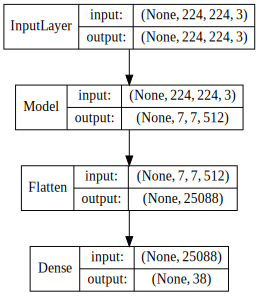


Visualization of Layers for:  ResNet50  base Model with Transfer Learning



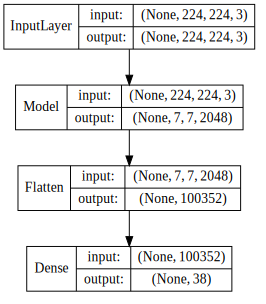


Visualization of Layers for:  InceptionV3  base Model with Transfer Learning



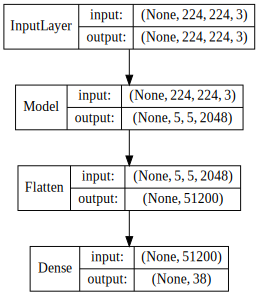


Visualization of Layers for:  Alexnet  base Model with Transfer Learning



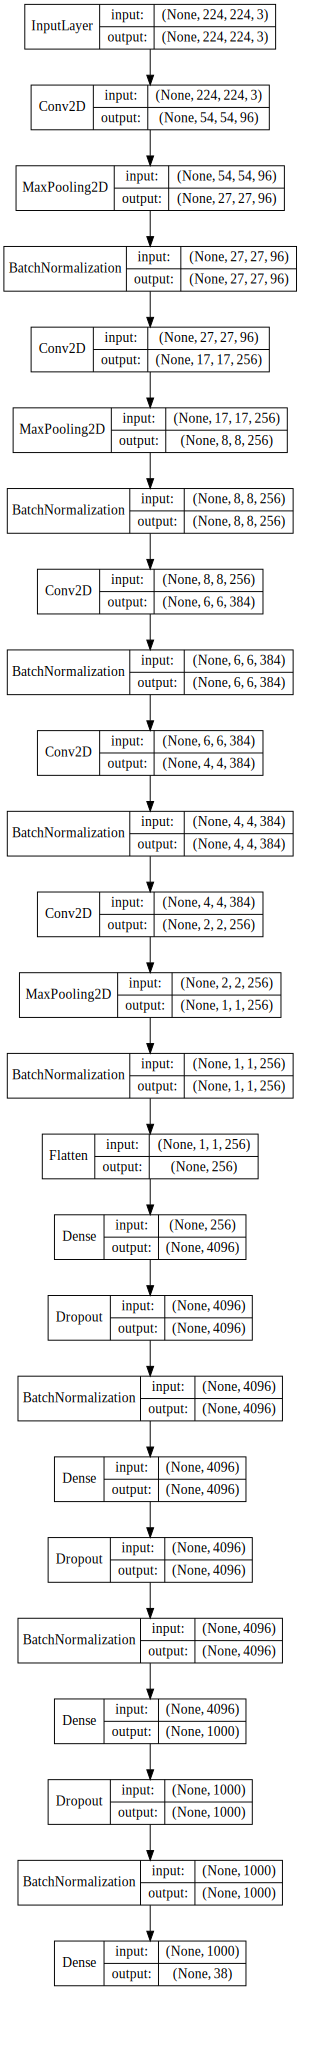

In [55]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Print Model Layers
for classifier, model_id in zip(models, model_ids):
    print('Visualization of Layers for: ', model_id, ' base Model with Transfer Learning')
    print('')
    display(SVG(model_to_dot(classifier, show_shapes=True, show_layer_names=False, dpi=70, rankdir='TB').create(prog='dot', format='svg')))
    print('')

Visualization of Layers for:  Model_A  base Model with Transfer Learning



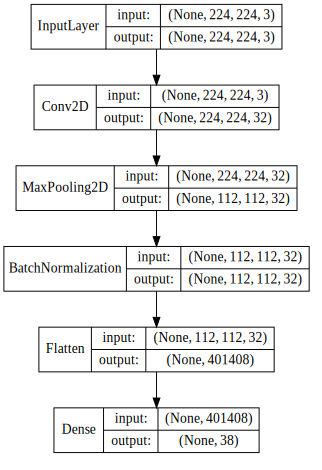


Visualization of Layers for:  Model_B  base Model with Transfer Learning



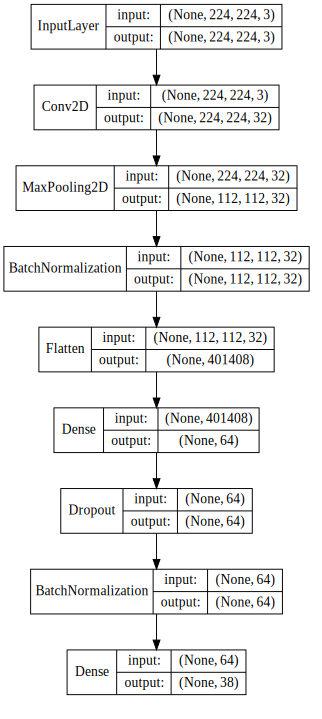


Visualization of Layers for:  Model_C  base Model with Transfer Learning



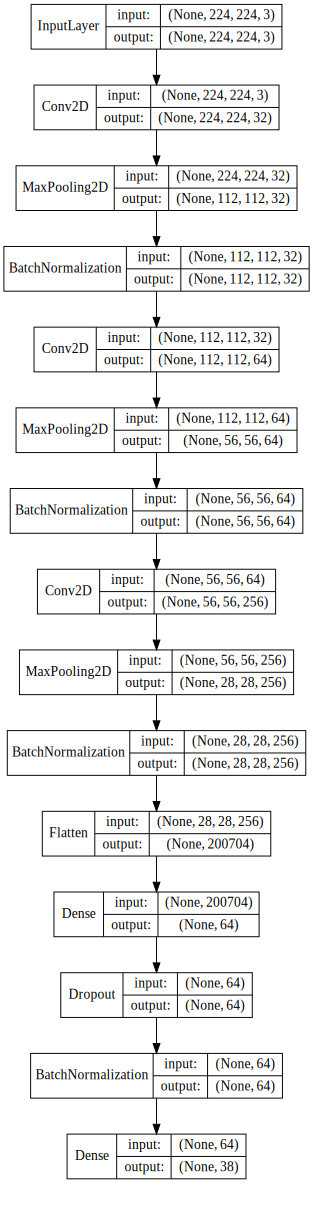


Visualization of Layers for:  Model_D  base Model with Transfer Learning



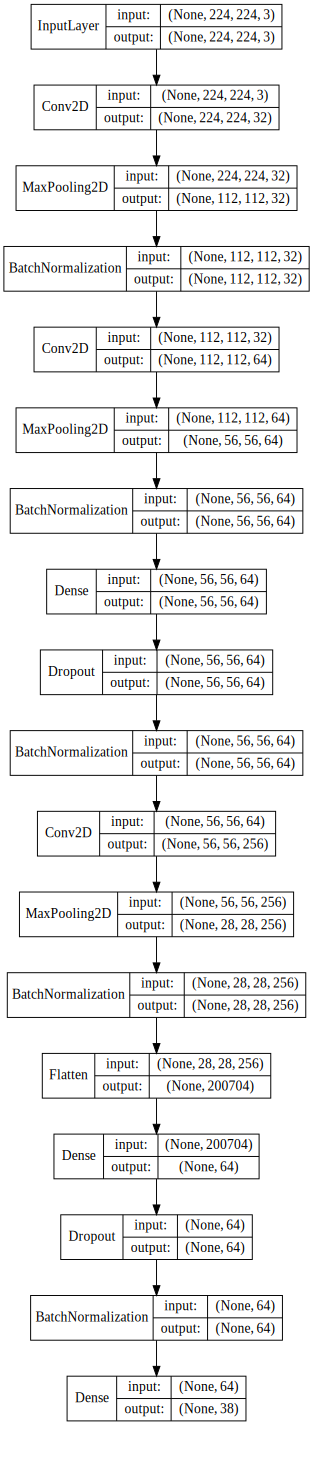

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Print Model Layers
for classifier, model_id in zip(models, model_ids):
    print('Visualization of Layers for: ', model_id, ' base Model with Transfer Learning')
    print('')
    display(SVG(model_to_dot(classifier, show_shapes=True, show_layer_names=False, dpi=70, rankdir='TB').create(prog='dot', format='svg')))
    print('')

#### Train Models

In [37]:
def Save_Model(model, model_id):
    filepath="./" + model_id + ".h5"
    classifier.save(filepath)

In [38]:
from keras.callbacks import ModelCheckpoint

# checkpoint for Alexnet Model
weightpath = "best_weights_9.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]# checkpoint
epochs = 3

# Initialize function
Save_Model_Benchmark("", "", False, True)

# Train Models and Save Histories
histories = []
for classifier, model_id in zip(models, model_ids):
    if model_id == 'Alexnet':
        history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, callbacks=callbacks_list, )  
    else:
          history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, )
    Save_Model_Benchmark(model_id, history, False, False)
    histories.append(history)
    Save_Model(classifier, model_id)

df_model_benchmarks

Epoch 1/3
1464/1464 [==============================] - 704s 481ms/step - loss: 8.6182 - accuracy: 0.6786 - val_loss: 4.6351 - val_accuracy: 0.7282
Epoch 2/3
1464/1464 [==============================] - 717s 490ms/step - loss: 0.6051 - accuracy: 0.9054 - val_loss: 0.7336 - val_accuracy: 0.7826
Epoch 3/3
1464/1464 [==============================] - 703s 480ms/step - loss: 0.2569 - accuracy: 0.9454 - val_loss: 1.2668 - val_accuracy: 0.7840
Epoch 1/3
1464/1464 [==============================] - 706s 482ms/step - loss: 1.1518 - accuracy: 0.6808 - val_loss: 0.3668 - val_accuracy: 0.8365
Epoch 2/3
1464/1464 [==============================] - 706s 483ms/step - loss: 0.4335 - accuracy: 0.8727 - val_loss: 0.3425 - val_accuracy: 0.8176
Epoch 3/3
1464/1464 [==============================] - 709s 484ms/step - loss: 0.2561 - accuracy: 0.9211 - val_loss: 0.2261 - val_accuracy: 0.8293
Epoch 1/3
1464/1464 [==============================] - 713s 487ms/step - loss: 0.9630 - accuracy: 0.7375 - val_loss: 0

,Classifier,Accuracy,Loss,Validation Accuracy,Validation Loss
0,Model_A,0.95,0.26,0.78,1.27
1,Model_B,0.92,0.26,0.83,0.23
2,Model_C,0.95,0.16,0.95,0.09
3,Model_D,0.91,0.30,0.94,0.27


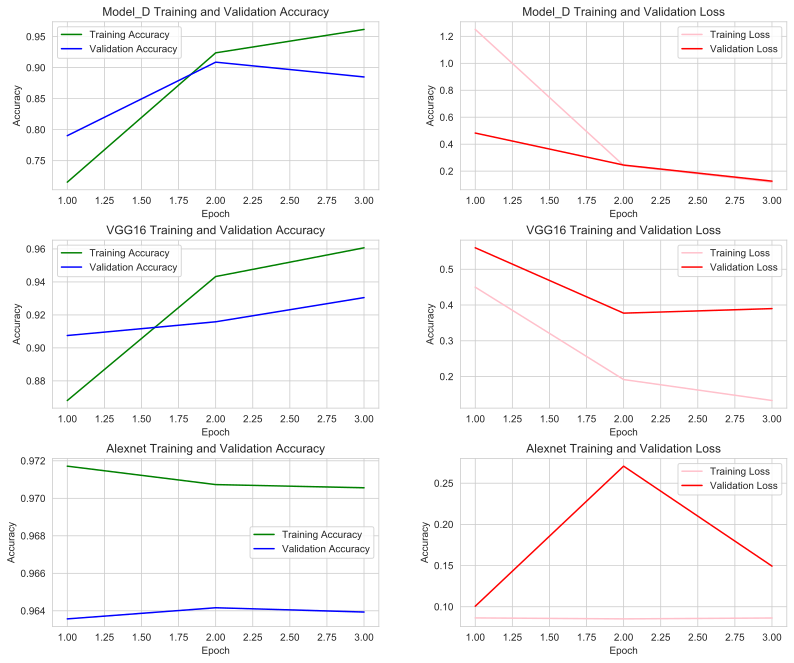

In [35]:
import matplotlib.gridspec as gridspec
import itertools

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(3, 2, figsize=(12,10))

row = 0
for history, model_id in zip(histories, model_ids): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

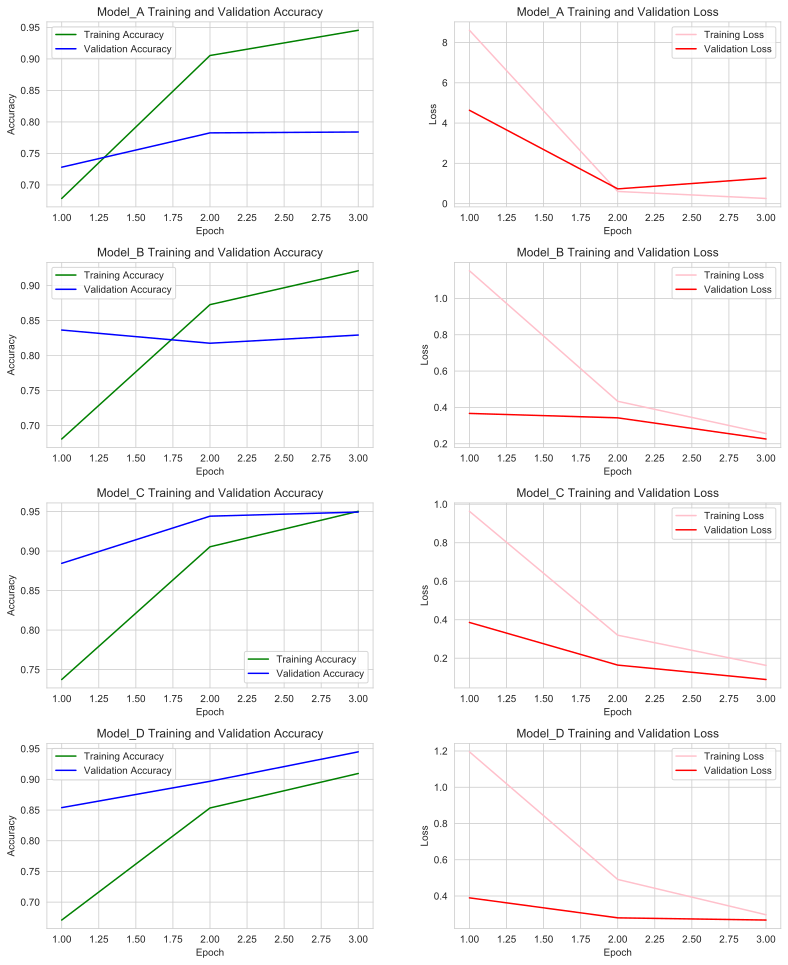

In [52]:
import matplotlib.gridspec as gridspec
import itertools

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(4, 2, figsize=(12,15))

row = 0
for history, model_id in zip(histories, model_ids): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

#### Plot Model Training Results

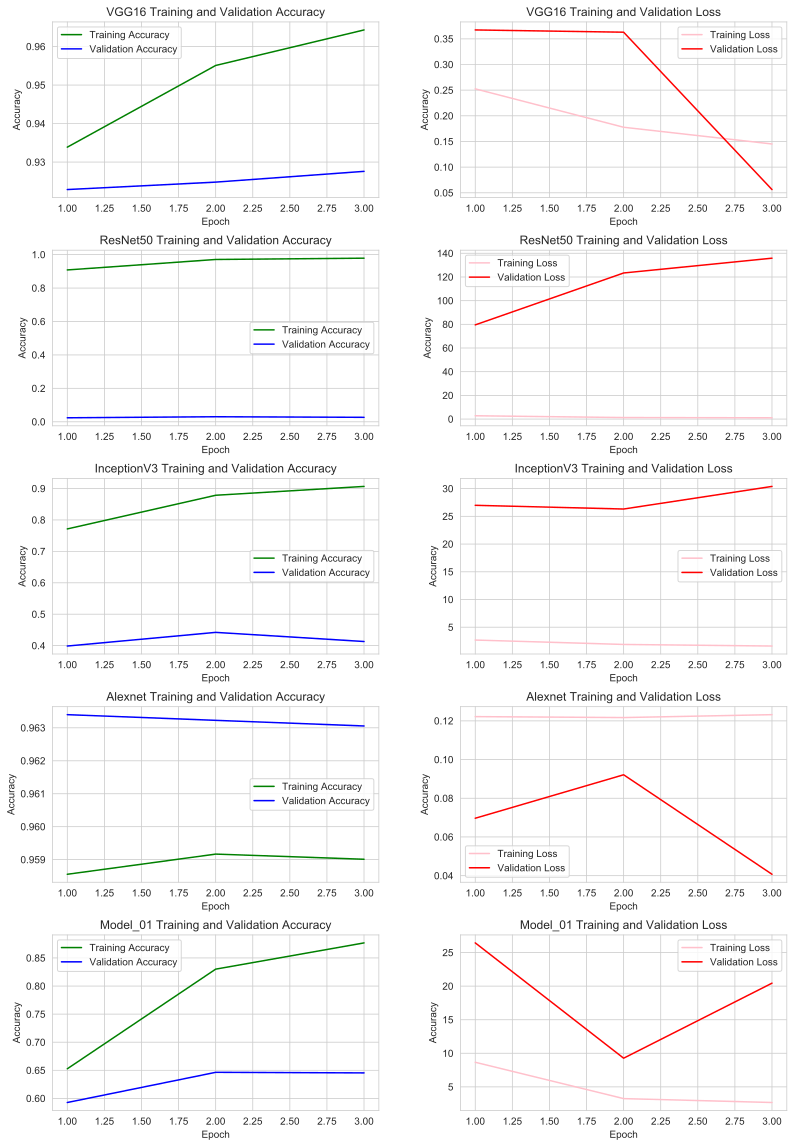

In [23]:
import matplotlib.gridspec as gridspec
import itertools

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(5, 2, figsize=(12,18))

row = 0
for history, model_id in zip(histories, model_ids): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

#### Perform Hyper-Parameter Tuning on Selected Model (Done in Plant_Disease_Detection_Augm_hp_tuning.ipynb due to errors in GPU mode.)

#### Re-Run Selected Model with Tuned Hyper-Parameters

In [57]:
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
import keras

def create_model_Vgg16(activation='softmax', learning_rate=0.01):
    base_model=VGG16(include_top=False,input_shape=(224,224,3))
    base_model.trainable=False

    classifier=keras.models.Sequential()
    classifier.add(base_model)
    classifier.add(Flatten())
    classifier.add(Dense(38,activation=activation))

    opt = Adam(lr=learning_rate)
    
    classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [58]:
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
import keras

def create_model_C(activation='softmax', learning_rate=0.01):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224,224,3)))
    classifier.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    classifier.add(Flatten())

    classifier.add(Dense(units = 64, activation = 'relu'))
    classifier.add(Dropout(0.3))
    classifier.add(BatchNormalization())

    #classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(38,activation=activation))
    
    opt = Adam(lr=learning_rate) 
    classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [59]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers
 
def create_model_alexnet(activation='softmax', learning_rate=0.01):
    # Initializing the CNN
    classifier = Sequential()
 
    # Convolution Step 1
    classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))
 
    # Max Pooling Step 1
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())
 
    # Convolution Step 2
    classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
 
    # Max Pooling Step 2
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
    classifier.add(BatchNormalization())
 
    # Convolution Step 3
    classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    classifier.add(BatchNormalization())
 
    # Convolution Step 4
    classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    classifier.add(BatchNormalization())
 
    # Convolution Step 5
    classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
 
    # Max Pooling Step 3
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())
 
    # Flattening Step
    classifier.add(Flatten())
 
    # Full Connection Step
    classifier.add(Dense(units = 4096, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 4096, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 1000, activation = 'relu'))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 38, activation = activation))
 
    classifier.load_weights('best_weights_9.hdf5')
 
    # we chose to train the top 2 conv blocks, i.e. we will freeze
    # the first 8 layers and unfreeze the rest:
    for i, layer in enumerate(classifier.layers[:20]):
        layer.trainable = False
 
    # Compiling the Model
    classifier.compile(optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9, decay=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

In [60]:
def Save_Tuned_Model_Benchmark(descr, history, reset_rb, init_rb):
    global rows_tuned_model_benchmarks
    global df_tuned_model_benchmarks
    if (init_rb):
        rows_tuned_model_benchmarks = []
    else:
        if (reset_rb):
            rows_tuned_model_benchmarks = []

        rows_tuned_model_benchmarks.append([descr, history.history['accuracy'][-1], history.history['loss'][-1], history.history['val_accuracy'][-1], 
            history.history['val_loss'][-1],])
        df_tuned_model_benchmarks = pd.DataFrame(rows_tuned_model_benchmarks, columns=["Classifier", "Accuracy", "Loss", "Validation Accuracy", "Validation Loss"])

In [61]:

hpt_model_ids = ['Alexnet_Tuned','Vgg16_Tuned','Model_C_Tuned']
hpt_models = [
    create_model_alexnet('softmax', 0.01),
    # create_model_Vgg16('softmax', 0.001),
    # create_model_C('softmax', 0.001),
]

In [65]:
from keras.callbacks import ModelCheckpoint

# checkpoint for Alexnet Model
weightpath = "best_weights_9.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]# checkpoint
# epochs_lst = [3, 5, 10]
# batch_sizes = [32, 64, 48]
epochs_lst = [3]
batch_sizes = [32]

# Initialize function
Save_Tuned_Model_Benchmark("", "", False, True)

# Train Models and Save Histories
histories = []
for classifier, model_id, epochs, batch_size in zip(hpt_models, hpt_model_ids, epochs_lst, batch_sizes):
    training_set = train_datagen.flow_from_directory(dataDirTrain, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
    valid_set = valid_datagen.flow_from_directory(dataDirValidate, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

    train_num = training_set.samples
    valid_num = valid_set.samples

    if model_id == 'Alexnet_Tuned':
        history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, callbacks=callbacks_list, )  
    else:
          history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, )
    Save_Tuned_Model_Benchmark(model_id, history, False, False)
    histories.append(history)
    Save_Model(classifier, 'HPT' + model_id)

df_model_benchmarks

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/3
2196/2196 [==============================] - 720s 328ms/step - loss: 0.1131 - accuracy: 0.9610 - val_loss: 0.0055 - val_accuracy: 0.9635
Epoch 2/3
2196/2196 [==============================] - 716s 326ms/step - loss: 0.1143 - accuracy: 0.9612 - val_loss: 0.0767 - val_accuracy: 0.9643
Epoch 3/3
2196/2196 [==============================] - 753s 343ms/step - loss: 0.1130 - accuracy: 0.9613 - val_loss: 0.2552 - val_accuracy: 0.9644


,Classifier,Accuracy,Loss,Validation Accuracy,Validation Loss
0,Model_A,0.95,0.26,0.78,1.27
1,Model_B,0.92,0.26,0.83,0.23
2,Model_C,0.95,0.16,0.95,0.09
3,Model_D,0.91,0.30,0.94,0.27


In [73]:
df_tuned_model_benchmarks

,Classifier,Accuracy,Loss,Validation Accuracy,Validation Loss
0,Alexnet_Tuned,0.96,0.11,0.96,0.26


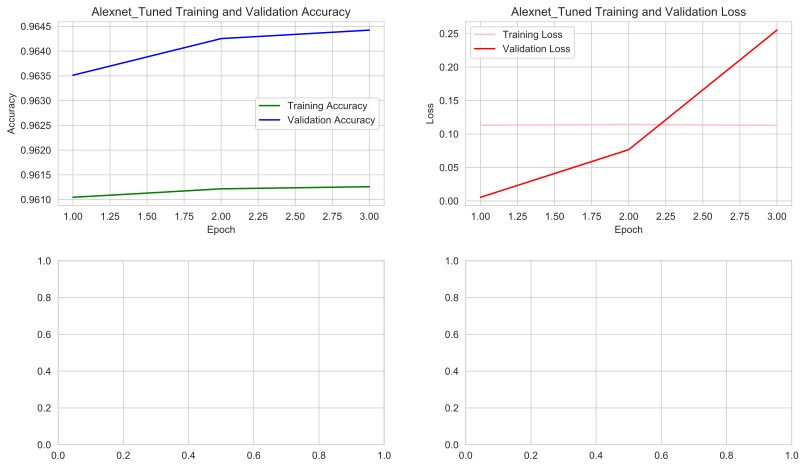

In [72]:
import matplotlib.gridspec as gridspec
import itertools

hpt_model_ids = ['Alexnet_Tuned']

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(2, 2, figsize=(12,7))

row = 0
for history, model_id in zip(histories, hpt_model_ids): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

In [44]:
batch_size = 48
learning_rate = 0.001
activation = 'softmax'
epochs = 10

# batch_size = 48
# learning_rate = 0.001
# activation = 'tanh'
# epochs = 3

classifier = create_model_C(activation, learning_rate)

history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, )    
Save_Tuned_Model_Benchmark("Model_C HP Tuned", history, False, False)
histories.append(history)

df_model_benchmarks

Epoch 1/10
1464/1464 [==============================] - 737s 504ms/step - loss: 1.0818 - accuracy: 0.7035 - val_loss: 0.4028 - val_accuracy: 0.8813
Epoch 2/10
1464/1464 [==============================] - 702s 479ms/step - loss: 0.3930 - accuracy: 0.8824 - val_loss: 0.3081 - val_accuracy: 0.8274
Epoch 3/10
 766/1464 [==============>...............] - ETA: 5:30 - loss: 0.2129 - accuracy: 0.9360

KeyboardInterrupt: 

#### Ensemble Model

In [45]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
 
# load models from file
def load_all_models(model_ids):
	all_models = list()
	for model_id in model_ids:
		# define filename for this ensemble
		filename = model_id + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	# hidden = Dense(10, activation='relu')(merge)
	# output = Dense(3, activation='softmax')(hidden)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy_enc, epochs=3, verbose=0)
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)

In [49]:
from deepstack.base import KerasMember

members = load_all_models(['Model_C', 'VGG16', 'Alexnet'])
# member1 = KerasMember(name="Model_C", keras_model=members[0], train_batches=(x_train, y_train), val_batches=(x_val, y_val))
# member2 = KerasMember(name="VGG16", keras_model=members[1], train_batches=(x_train, y_train), val_batches=(x_val, y_val))
# member3 = KerasMember(name="Alexnet", keras_model=members[2], train_batches=(x_train, y_train), val_batches=(x_val, y_val))

member1 = KerasMember(name="Model_C", keras_model=members[0], train_batches=training_set, val_batches=valid_set)
member2 = KerasMember(name="VGG16", keras_model=members[1], train_batches=training_set, val_batches=valid_set)
member3 = KerasMember(name="Alexnet", keras_model=members[2], train_batches=training_set, val_batches=valid_set)



>loaded Model_C.h5
>loaded VGG16.h5
>loaded Alexnet.h5
367/367 [==============================] - 28s 76ms/step


In [50]:
from deepstack.ensemble import DirichletEnsemble
from sklearn.metrics import accuracy_score

wAvgEnsemble = DirichletEnsemble(metric=accuracy_score)
wAvgEnsemble.add_members([member1, member2, member3])
wAvgEnsemble.fit()
wAvgEnsemble.describe()

Model_C - Weight: 0.0051 - accuracy_score: 0.5012
VGG16 - Weight: 0.0015 - accuracy_score: 0.5003
Alexnet - Weight: 0.9934 - accuracy_score: 0.9998
DirichletEnsemble accuracy_score: 0.9998


In [46]:
# # generate 2d classification dataset
# #X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# # split into train and test
# #n_train = 100
# # trainX, testX = X[:n_train, :], X[n_train:, :]
# # trainy, testy = y[:n_train], y[n_train:]
# trainX, trainy = next(training_set)
# testX, testy = next(valid_set)
# print(trainX.shape, testX.shape)
# # load all models
# n_members = 3
# members = load_all_models(['Model_03', 'VGG16', 'Alexnet'])
# print('Loaded %d models' % len(members))
# # define ensemble model
# stacked_model = define_stacked_model(members)
# # fit stacked model on test dataset
# fit_stacked_model(stacked_model, testX, testy)
# # make predictions and evaluate
# yhat = predict_stacked_model(stacked_model, testX)
# yhat = argmax(yhat, axis=1)
# acc = accuracy_score(testy, yhat)
# print('Stacked Test Accuracy: %.3f' % acc)

(48, 224, 224, 3) (48, 224, 224, 3)
>loaded Model_03.h5
>loaded VGG16.h5
>loaded Alexnet.h5
Loaded 3 models


ValueError: Error when checking target: expected dense_17 to have 2 dimensions, but got array with shape (48, 38, 2)

In [27]:
# Save Final Model
filepath="./Mymodel_sample.h5"
classifier.save(filepath)

#### Inference

In [41]:
class_dict = training_set.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato_

In [42]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot', 'Corn_(maize)___Common_rust', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites_Two-spotted_spider_mite', 'Tomato___Target_Spo

Following is our prediction:


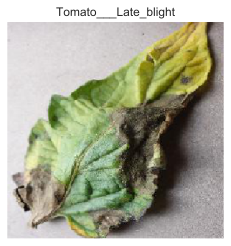

In [43]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "../NewPlantDiseasesDataset/test/Tomato_Late_blight01.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

filename = 'Model_D.h5'
# load model from file
classifier = load_model(filename)

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()